In [41]:
import pandas as pd
import psycopg2
import dotenv
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import warnings
from lifetimes import BetaGeoFitter

#### PUXANDO DADOS DA GCP

In [42]:
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

dotenv.load_dotenv()
# Configuração da conexão
config = {
    "host":     os.getenv("host_gcp"),
    "dbname":   "espantalhopneus",
    "user":     os.getenv("meuUser"),
    "password": os.getenv("minhaSenha"),
    "port":     os.getenv("port_gcp")
}

try:
    # Conectar ao banco e criar cursor
    conn = psycopg2.connect(**config)
    cursor = conn.cursor()
    print("Conectado!")

    # Executar a query na tabela vendas
    query = "SELECT * FROM vendas;"
    cursor.execute(query)
    
    # Obter todas as linhas retornadas
    linhas = cursor.fetchall()
    
    # Obter os nomes das colunas a partir do cursor.description
    colunas = [desc[0] for desc in cursor.description]
    
    # Criar o DataFrame com os dados e as colunas
    df_vendas = pd.DataFrame(linhas, columns=colunas)

    query = "SELECT * FROM clientes;"
    cursor.execute(query)
    linhas = cursor.fetchall()
    colunas = [desc[0] for desc in cursor.description]
    df_clientes = pd.DataFrame(linhas, columns=colunas)

    query = "SELECT * FROM clientesPessoaFisica;"
    cursor.execute(query)
    linhas = cursor.fetchall()
    colunas = [desc[0] for desc in cursor.description]
    df_clientes_PF = pd.DataFrame(linhas, columns=colunas)
    
    # Exibir as primeiras linhas do DataFrame vendas e clientes
    print("TABLE VENDAS")
    print(df_vendas.head())
    
    print("\n\nTABLE CLIENTES")
    print(df_clientes.head())

    print("\n\nTABLE CLIENTES_PF")
    print(df_clientes_PF.head())
    
    # Fechar cursor e conexão
    cursor.close()
    conn.close()
    print("fechando cursor e conn")
except Exception as e:
    print(f"Erro ao conectar ou executar a query: {e}")

Conectado!
TABLE VENDAS
   id_venda  id_cliente  id_loja  data_venda total_venda total_custo  \
0    610621           8        3  2018-04-01       20.00        0.00   
1    620575        8680        1  2018-04-01      560.00      395.56   
2    620576        8680        1  2018-04-01      140.00        0.00   
3    620579       10717        1  2018-04-01     3380.00     2198.24   
4    620580       10717        1  2018-04-01      280.00        0.00   

      forma_pagamento status desconto_total  
0        1 - DINHEIRO  Venda           0.00  
1        1 - DINHEIRO  Venda           0.00  
2        1 - DINHEIRO  Venda           0.00  
3  3 - CARTÃO CREDITO  Venda           0.00  
4  3 - CARTÃO CREDITO  Venda           0.00  


TABLE CLIENTES
   id_cliente tipo_cliente                       email       telefone  \
0           1            J  FISCADM12CIAPE@HOTMAIL.COM   92 3659-1181   
1           2            F                              92 99142-5533   
2           3            J     

#### ANÁLISE EXPLORATÓRIA VENDAS E CLIENTES

In [43]:
# 1. Quantos id_cliente únicos?
unique_clientes = df_vendas['id_cliente'].nunique()
print(f"Quantidade de id_cliente únicos: {unique_clientes}")

# 2. Quantos id_loja únicos?
unique_lojas = df_vendas['id_loja'].nunique()
print(f"Quantidade de id_loja únicos: {unique_lojas}")

# 3. Quantos status únicos?
unique_status = df_vendas['status'].nunique()
print(f"Quantidade de status únicos: {unique_status}")

# Imprime os valores únicos de status
status_valores = df_vendas['status'].unique()
print("Status encontrados:", status_valores)

# 4. Análise exploratória sobre a receita utilizando total_venda
print("\nAnálise exploratória da receita (total_venda):")
print(df_vendas['total_venda'].describe())

Quantidade de id_cliente únicos: 121113
Quantidade de id_loja únicos: 4
Quantidade de status únicos: 2
Status encontrados: ['Venda' 'Devolução']

Análise exploratória da receita (total_venda):
count     553073
unique     35003
top       180.00
freq       41727
Name: total_venda, dtype: object


Quantidade de clientes únicos por tipo_cliente:
tipo_cliente
F    115099
J      6014
Name: id_cliente, dtype: int64


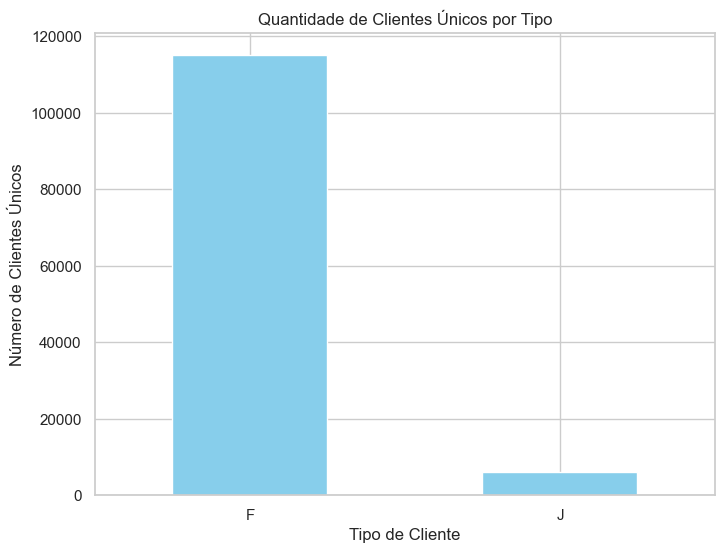

In [44]:
clientes_por_tipo = df_clientes.groupby('tipo_cliente')['id_cliente'].nunique()

print("Quantidade de clientes únicos por tipo_cliente:")
print(clientes_por_tipo)

# Opcional: Visualizando o resultado com um gráfico de barras
clientes_por_tipo.plot(kind='bar', color='skyblue', figsize=(8,6))
plt.title('Quantidade de Clientes Únicos por Tipo')
plt.xlabel('Tipo de Cliente')
plt.ylabel('Número de Clientes Únicos')
plt.xticks(rotation=0)
plt.show()

#### ADICIONAR COLUNA TIPO_CLIENTE NA BASE DE VENDAS E FILTRAR PARA TER SOMENTE PF

In [45]:
df_vendas = df_vendas.merge(df_clientes[['id_cliente', 'tipo_cliente']], on='id_cliente', how='left')
df_vendas = df_vendas[df_vendas['tipo_cliente'] == 'F']
#print do nunero de clientes deve ser igual ao numero de clientes únicos PF, que foi apresentado na análise exploratória dos clientes
unique_clientes = df_vendas['id_cliente'].nunique()
print(f"Número de Clientes PF: {unique_clientes}")

Número de Clientes PF: 115099


#### ANÁLISE DE RECORRÊNCIA MENSAL

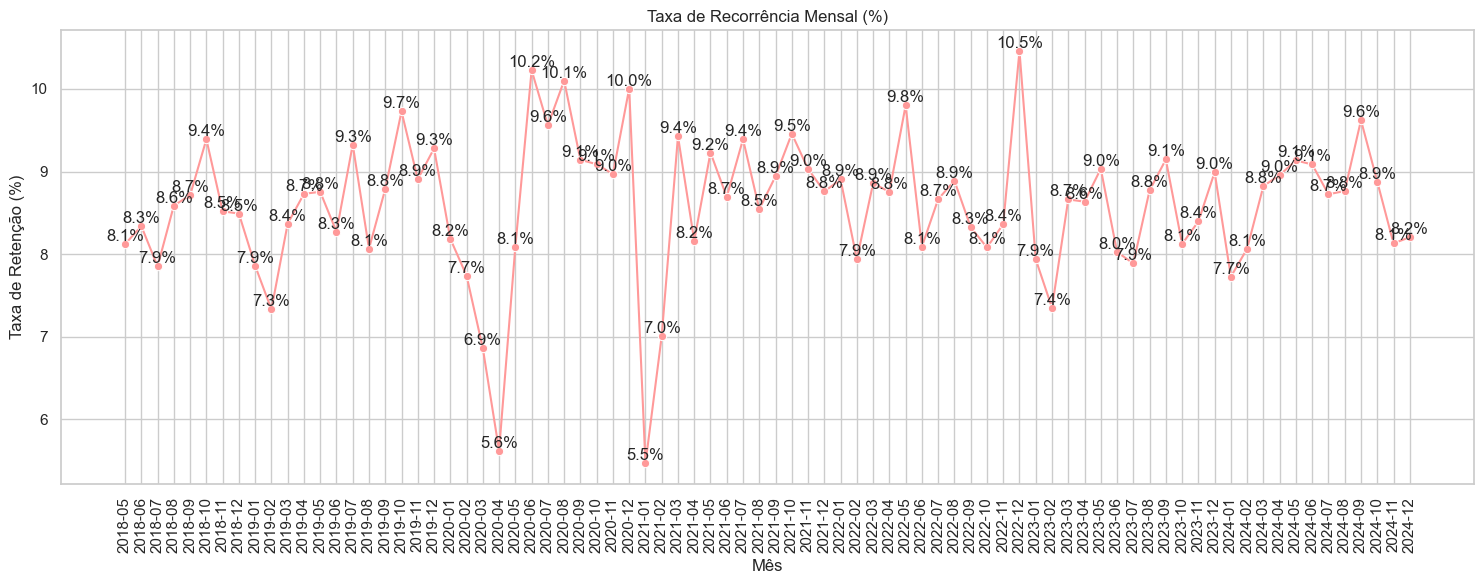


Resultados salvos em metricas_recorrencia_mensal.xlsx

Métricas de Recorrência:
yearmonth  retained_customers  prev_total_customers  retention_rate
  2018-05                 236                  2906        8.121129
  2018-06                 233                  2794        8.339298
  2018-07                 251                  3197        7.851110
  2018-08                 301                  3505        8.587732
  2018-09                 295                  3386        8.712345
  2018-10                 285                  3035        9.390445
  2018-11                 302                  3545        8.519041
  2018-12                 307                  3616        8.490044
  2019-01                 291                  3703        7.858493
  2019-02                 262                  3574        7.330722
  2019-03                 273                  3262        8.369099
  2019-04                 310                  3551        8.729935
  2019-05                 312      

In [46]:
# Criar um DataFrame com mês e cliente
df_vendas['data_venda'] = pd.to_datetime(df_vendas['data_venda'])
monthly_customers = df_vendas.groupby([df_vendas['data_venda'].dt.strftime('%Y-%m'), 'id_cliente']).size().reset_index()
monthly_customers.columns = ['yearmonth', 'id_cliente', 'count']

# Criar um pivot para facilitar a comparação entre meses
customer_matrix = monthly_customers.pivot_table(
    index='id_cliente',
    columns='yearmonth',
    values='count',
    fill_value=0
).astype(bool).astype(int)

# Calcular retenção
retention_rates = []
months = sorted(customer_matrix.columns)

for i in range(1, len(months)):
    prev_month = months[i-1]
    current_month = months[i]
    
    # Total de clientes no mês anterior
    prev_customers = customer_matrix[prev_month].sum()
    
    # Clientes que permaneceram
    retained = ((customer_matrix[prev_month] == 1) & (customer_matrix[current_month] == 1)).sum()
    
    # Calcular taxa
    retention_rate = (retained / prev_customers * 100) if prev_customers > 0 else 0
    
    retention_rates.append({
        'yearmonth': current_month,
        'retained_customers': retained,
        'prev_total_customers': prev_customers,
        'retention_rate': retention_rate
    })

retention_metrics = pd.DataFrame(retention_rates)

# Visualizar resultado
plt.figure(figsize=(15, 6))
sns.lineplot(data=retention_metrics, x='yearmonth', y='retention_rate', marker='o', color='#FF9999')
plt.title('Taxa de Recorrência Mensal (%)')
plt.xlabel('Mês')
plt.ylabel('Taxa de Retenção (%)')
plt.xticks(rotation=90)

# Adicionar valores sobre os pontos
for i, v in enumerate(retention_metrics['retention_rate']):
    if pd.notnull(v) and v != 0:
        plt.text(i, v, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Salvar resultados
retention_metrics.to_excel('metricas_recorrencia_mensal.xlsx', index=False)
print("\nResultados salvos em metricas_recorrencia_mensal.xlsx")

# Imprimir métricas
print("\nMétricas de Recorrência:")
print(retention_metrics.to_string(index=False))


# Estatísticas resumidas
print("\nEstatísticas de Recorrência:")
print(f"Taxa média de retenção: {retention_metrics['retention_rate'].mean():.1f}%")
print(f"Taxa máxima de retenção: {retention_metrics['retention_rate'].max():.1f}%")
print(f"Taxa mínima de retenção: {retention_metrics['retention_rate'].min():.1f}%")

#### ANÁLISE DE RECORRÊNCIA TRIMESTRAL

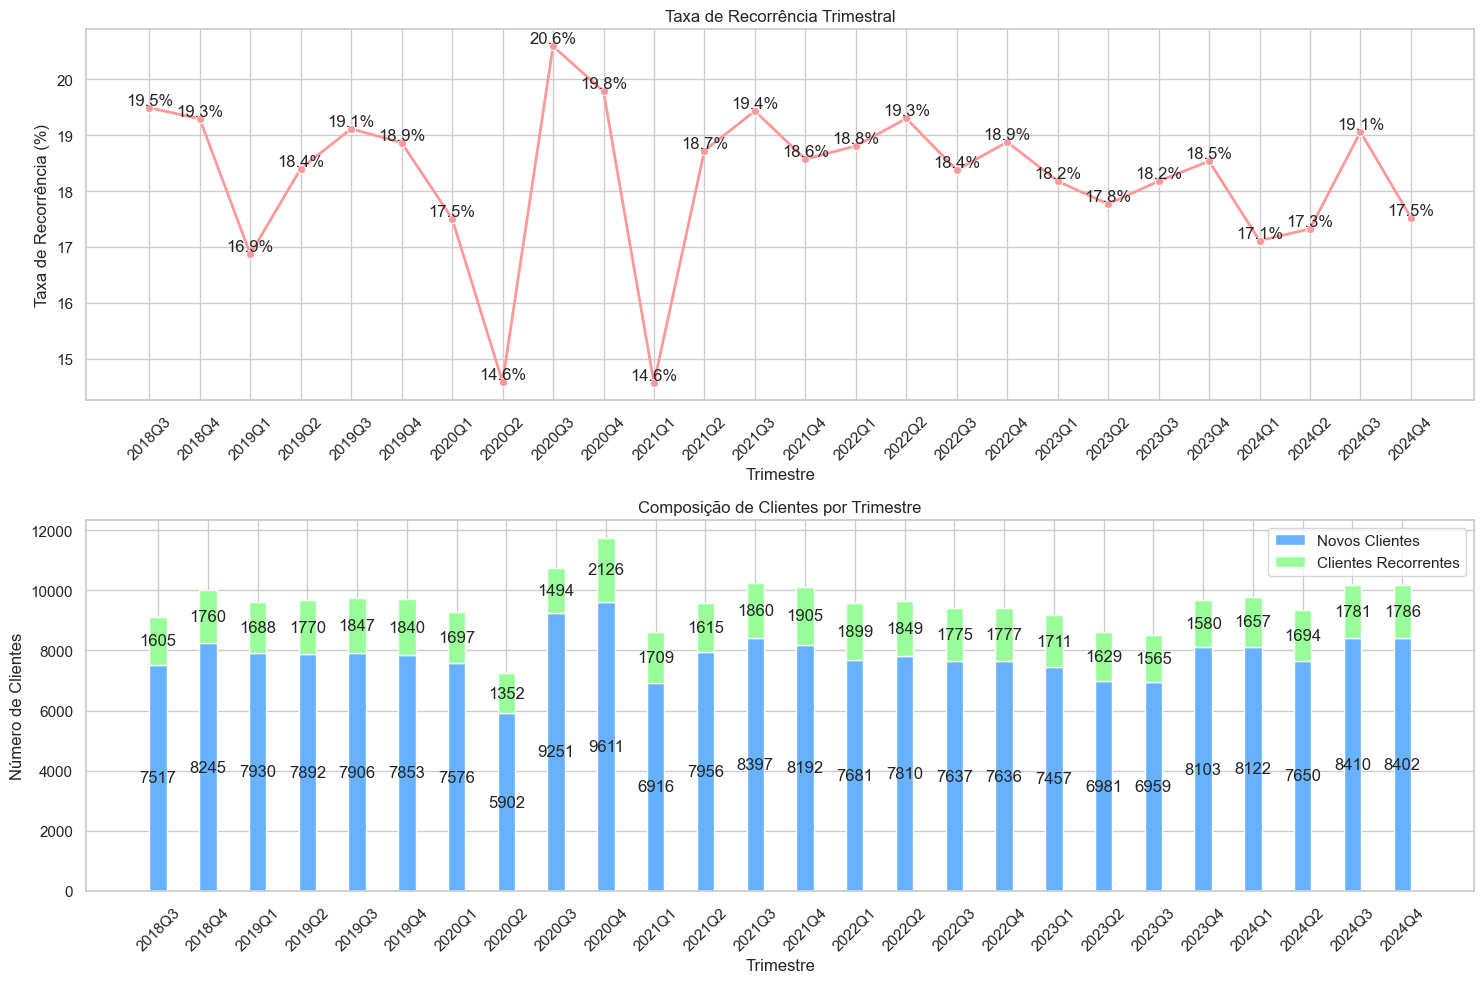


Resultados salvos em metricas_recorrencia_trimestral.xlsx

Métricas Trimestrais:
trimestre  total_customers  returning_customers  new_customers  recurrence_rate
   2018Q3             9122                 1605           7517        19.492349
   2018Q4            10005                 1760           8245        19.294014
   2019Q1             9618                 1688           7930        16.871564
   2019Q2             9662                 1770           7892        18.402994
   2019Q3             9753                 1847           7906        19.116125
   2019Q4             9693                 1840           7853        18.865990
   2020Q1             9273                 1697           7576        17.507480
   2020Q2             7254                 1352           5902        14.579963
   2020Q3            10745                 1494           9251        20.595533
   2020Q4            11737                 2126           9611        19.785947
   2021Q1             8625            

In [47]:
# Criar trimestre para cada compra
df_vendas['trimestre'] = df_vendas['data_venda'].dt.to_period('Q')

# Criar DataFrame de clientes por trimestre
quarterly_customers = df_vendas.groupby(['trimestre', 'id_cliente']).size().reset_index()
quarterly_customers.columns = ['trimestre', 'id_cliente', 'count']

# Criar pivot para análise trimestral
customer_matrix = quarterly_customers.pivot_table(
    index='id_cliente',
    columns='trimestre',
    values='count',
    fill_value=0
).astype(bool).astype(int)

# Calcular recorrência trimestral
quarterly_metrics = []
quarters = sorted(customer_matrix.columns)

for i in range(1, len(quarters)):
    current_quarter = quarters[i]
    prev_quarter = quarters[i-1]
    
    # Total de clientes no trimestre anterior
    prev_customers = customer_matrix[prev_quarter].sum()
    
    # Clientes que voltaram
    returning = ((customer_matrix[prev_quarter] == 1) & (customer_matrix[current_quarter] == 1)).sum()
    
    # Novos clientes (não compraram no trimestre anterior)
    new_customers = (customer_matrix[current_quarter] & ~customer_matrix[prev_quarter]).sum()
    
    # Total de clientes no trimestre atual
    total_customers = customer_matrix[current_quarter].sum()
    
    # Calcular taxas
    recurrence_rate = (returning / prev_customers * 100) if prev_customers > 0 else 0
    
    quarterly_metrics.append({
        'trimestre': str(current_quarter),  # Convertendo para string
        'trimestre_obj': current_quarter,   # Mantendo o objeto período para ordenação
        'total_customers': total_customers,
        'returning_customers': returning,
        'new_customers': new_customers,
        'recurrence_rate': recurrence_rate
    })

quarterly_df = pd.DataFrame(quarterly_metrics)
quarterly_df = quarterly_df.sort_values('trimestre_obj')  # Ordenar pelos trimestres

# Visualizações
plt.figure(figsize=(15, 10))

# Gráfico 1: Taxa de Recorrência
plt.subplot(2, 1, 1)
sns.lineplot(data=quarterly_df, x='trimestre', y='recurrence_rate', marker='o', color='#FF9999', linewidth=2)
plt.title('Taxa de Recorrência Trimestral')
plt.xlabel('Trimestre')
plt.ylabel('Taxa de Recorrência (%)')
plt.xticks(rotation=45)

# Adicionar valores sobre os pontos
for i, row in enumerate(quarterly_df.itertuples()):
    if pd.notnull(row.recurrence_rate) and row.recurrence_rate != 0:
        plt.text(i, row.recurrence_rate, f'{row.recurrence_rate:.1f}%', ha='center', va='bottom')

# Gráfico 2: Composição de Clientes por Trimestre
plt.subplot(2, 1, 2)
width = 0.35
x = range(len(quarterly_df))

plt.bar(x, quarterly_df['new_customers'], width, label='Novos Clientes', color='#66B2FF')
plt.bar(x, quarterly_df['returning_customers'], width, bottom=quarterly_df['new_customers'],
        label='Clientes Recorrentes', color='#99FF99')

plt.xlabel('Trimestre')
plt.ylabel('Número de Clientes')
plt.title('Composição de Clientes por Trimestre')
plt.xticks(x, quarterly_df['trimestre'], rotation=45)
plt.legend()

# Adicionar valores nas barras
for i in range(len(quarterly_df)):
    # Valor para novos clientes
    plt.text(i, quarterly_df['new_customers'].iloc[i]/2, 
             str(quarterly_df['new_customers'].iloc[i]),
             ha='center', va='center')
    
    # Valor para clientes recorrentes
    plt.text(i, quarterly_df['new_customers'].iloc[i] + quarterly_df['returning_customers'].iloc[i]/2,
             str(quarterly_df['returning_customers'].iloc[i]),
             ha='center', va='center')

plt.tight_layout()
plt.show()

# Salvar resultados
quarterly_df.to_excel('metricas_recorrencia_trimestral.xlsx', index=False)
print("\nResultados salvos em metricas_recorrencia_trimestral.xlsx")

# Imprimir métricas (removendo a coluna trimestre_obj para melhor visualização)
print("\nMétricas Trimestrais:")
print(quarterly_df.drop('trimestre_obj', axis=1).to_string(index=False))

# Estatísticas resumidas
print("\nEstatísticas de Recorrência Trimestral:")
print(f"Taxa média de recorrência: {quarterly_df['recurrence_rate'].mean():.1f}%")
print(f"Taxa máxima de recorrência: {quarterly_df['recurrence_rate'].max():.1f}%")
print(f"Taxa mínima de recorrência: {quarterly_df['recurrence_rate'].min():.1f}%")
print(f"\nMédia de novos clientes por trimestre: {quarterly_df['new_customers'].mean():.0f}")
print(f"Média de clientes recorrentes por trimestre: {quarterly_df['returning_customers'].mean():.0f}")

#### ANÁLISE DE RECORRÊNCIA ANUAL

/var/folders/8y/5ndc5qwd1b38zpft_5ptb5280000gq/T/ipykernel_26582/380168163.py:68: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  line = ax2.plot(x, annual_df['retention_rate'], 'r--', label='Taxa de Retenção',


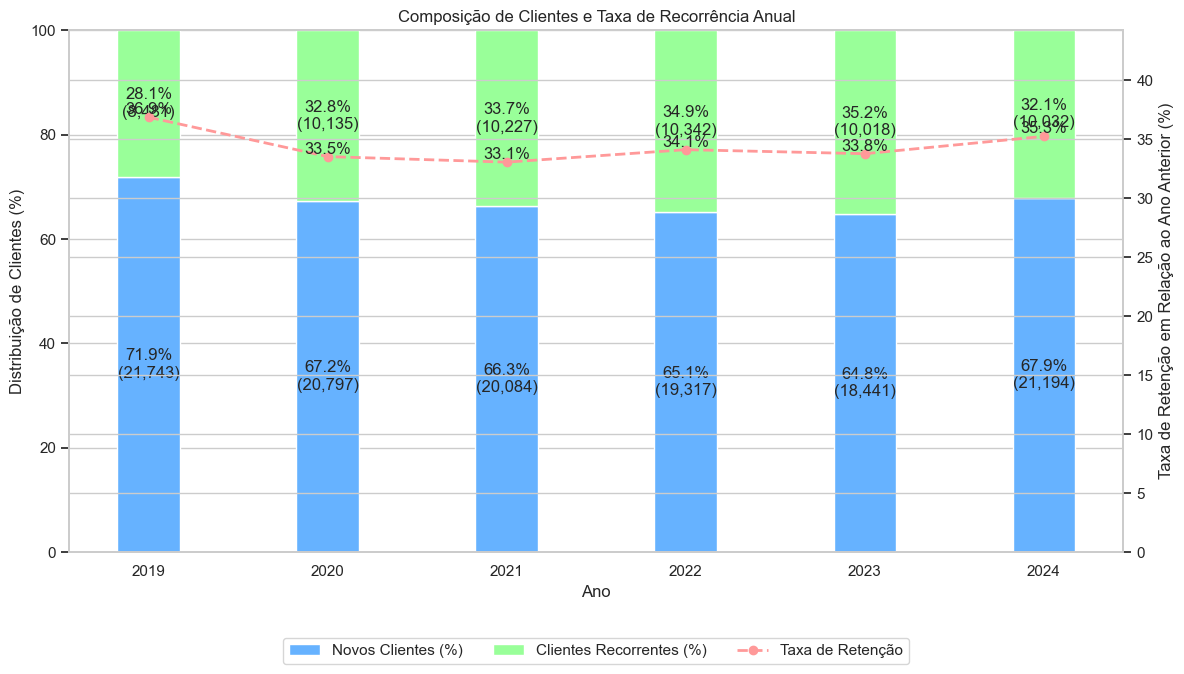


Resultados salvos em metricas_recorrencia_anual.xlsx

Métricas Anuais:
 ano  total_customers  returning_customers  new_customers  retention_rate  new_rate  returning_rate
2019            30224                 8481          21743       36.870707 71.939518       28.060482
2020            30932                10135          20797       33.532954 67.234579       32.765421
2021            30311                10227          20084       33.062848 66.259774       33.740226
2022            29659                10342          19317       34.119627 65.130315       34.869685
2023            28459                10018          18441       33.777268 64.798482       35.201518
2024            31226                10032          21194       35.250712 67.872926       32.127074

Estatísticas de Recorrência Anual:
Taxa média de retenção: 34.4%
Taxa média de novos clientes: 67.2%
Taxa média de recorrentes: 32.8%


In [48]:
# Criar ano para cada compra
df_vendas['ano'] = df_vendas['data_venda'].dt.to_period('Y')

# Criar DataFrame de clientes por ano
annual_customers = df_vendas.groupby(['ano', 'id_cliente']).size().reset_index()
annual_customers.columns = ['ano', 'id_cliente', 'count']

# Criar pivot para análise anual
customer_matrix = annual_customers.pivot_table(
    index='id_cliente',
    columns='ano',
    values='count',
    fill_value=0
).astype(bool).astype(int)

# Calcular métricas anuais
annual_metrics = []
years = sorted(customer_matrix.columns)

for i in range(1, len(years)):
    current_year = years[i]
    prev_year = years[i-1]
    
    # Total de clientes no ano anterior
    prev_customers = customer_matrix[prev_year].sum()
    
    # Clientes que voltaram
    returning = ((customer_matrix[prev_year] == 1) & (customer_matrix[current_year] == 1)).sum()
    
    # Novos clientes (não compraram no ano anterior)
    new_customers = (customer_matrix[current_year] & ~customer_matrix[prev_year]).sum()
    
    # Total de clientes no ano atual
    total_customers = customer_matrix[current_year].sum()
    
    # Calcular taxas
    retention_rate = (returning / prev_customers * 100) if prev_customers > 0 else 0
    new_rate = (new_customers / total_customers * 100) if total_customers > 0 else 0
    returning_rate = (returning / total_customers * 100) if total_customers > 0 else 0
    
    annual_metrics.append({
        'ano': str(current_year),
        'ano_obj': current_year,
        'total_customers': total_customers,
        'returning_customers': returning,
        'new_customers': new_customers,
        'retention_rate': retention_rate,  # Taxa de retenção em relação ao ano anterior
        'new_rate': new_rate,  # % de novos clientes no total
        'returning_rate': returning_rate  # % de clientes recorrentes no total
    })

annual_df = pd.DataFrame(annual_metrics)
annual_df = annual_df.sort_values('ano_obj')

# Visualização
plt.figure(figsize=(12, 7))  # Aumentado ligeiramente a altura para acomodar a legenda
ax1 = plt.gca()
x = np.arange(len(annual_df))
width = 0.35

# Plotar barras empilhadas com percentuais
bars1 = ax1.bar(x, annual_df['new_rate'], width, label='Novos Clientes (%)', color='#66B2FF')
bars2 = ax1.bar(x, annual_df['returning_rate'], width, bottom=annual_df['new_rate'],
                label='Clientes Recorrentes (%)', color='#99FF99')

# Plotar linha de retenção
ax2 = ax1.twinx()
line = ax2.plot(x, annual_df['retention_rate'], 'r--', label='Taxa de Retenção',
                color='#FF9999', linewidth=2, marker='o')

# Adicionar valores
for i in range(len(annual_df)):
    # Valores percentuais de novos clientes
    ax1.text(i, annual_df['new_rate'].iloc[i]/2,
             f'{annual_df["new_rate"].iloc[i]:.1f}%\n({annual_df["new_customers"].iloc[i]:,})',
             ha='center', va='center')
    
    # Valores percentuais de clientes recorrentes
    ax1.text(i, annual_df['new_rate'].iloc[i] + annual_df['returning_rate'].iloc[i]/2,
             f'{annual_df["returning_rate"].iloc[i]:.1f}%\n({annual_df["returning_customers"].iloc[i]:,})',
             ha='center', va='center')
    
    # Valores de taxa de retenção
    ax2.text(i, annual_df['retention_rate'].iloc[i],
             f'{annual_df["retention_rate"].iloc[i]:.1f}%',
             ha='center', va='bottom')

# Configurar eixos
ax1.set_xlabel('Ano')
ax1.set_ylabel('Distribuição de Clientes (%)')
ax2.set_ylabel('Taxa de Retenção em Relação ao Ano Anterior (%)')

# Ajustar limites
ax1.set_ylim(0, 100)
ax2.set_ylim(0, max(annual_df['retention_rate']) * 1.2)

# Configurar ticks
plt.xticks(x, annual_df['ano'], rotation=45)

# Adicionar legendas fora do gráfico
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
# Posicionar a legenda abaixo do gráfico
ax1.legend(lines1 + lines2, labels1 + labels2, 
           bbox_to_anchor=(0.5, -0.15),  # Posição x, y da legenda
           loc='upper center',  # Ponto de ancoragem da legenda
           ncol=3,  # Número de colunas na legenda
           bbox_transform=ax1.transAxes)  # Usar coordenadas do eixo

plt.title('Composição de Clientes e Taxa de Recorrência Anual')
plt.tight_layout()  # Ajustar layout para acomodar a legenda
plt.subplots_adjust(bottom=0.2)  # Ajustar espaço inferior para a legenda
plt.show()

# Salvar resultados
annual_df.to_excel('metricas_recorrencia_anual.xlsx', index=False)
print("\nResultados salvos em metricas_recorrencia_anual.xlsx")

# Imprimir estatísticas
print("\nMétricas Anuais:")
print(annual_df.drop('ano_obj', axis=1).to_string(index=False))

print("\nEstatísticas de Recorrência Anual:")
print(f"Taxa média de retenção: {annual_df['retention_rate'].mean():.1f}%")
print(f"Taxa média de novos clientes: {annual_df['new_rate'].mean():.1f}%")
print(f"Taxa média de recorrentes: {annual_df['returning_rate'].mean():.1f}%")

#### ANÁLISE TRIMESTRAL DE RETENÇÃO POR SAFRAS DE CLIENTES

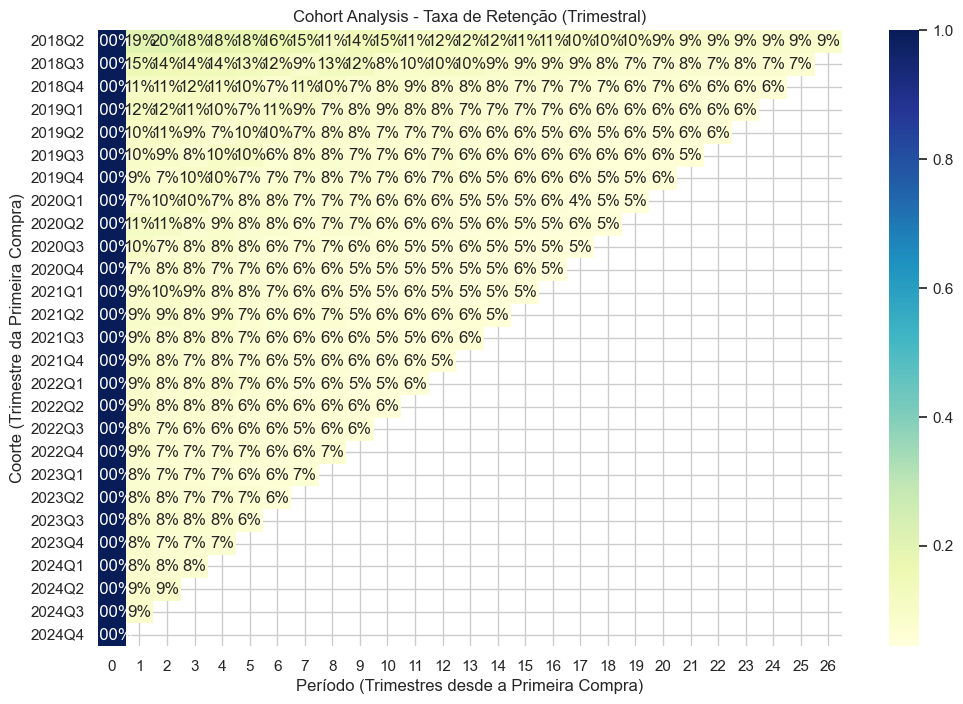

Tabela de Retenção por Coorte (Trimestral):
period_index     0         1         2         3         4         5   \
cohort_quarter                                                          
2018Q2          1.0  0.194923  0.198081  0.180836  0.179500  0.175370   
2018Q3          1.0  0.149395  0.144073  0.137688  0.136491  0.127711   
2018Q4          1.0  0.110743  0.114743  0.120121  0.111571  0.096676   
2019Q1          1.0  0.117091  0.116290  0.108121  0.097229  0.074804   
2019Q2          1.0  0.103473  0.106516  0.092374  0.069101  0.096312   
2019Q3          1.0  0.096124  0.092208  0.077330  0.101410  0.100822   
2019Q4          1.0  0.086767  0.068248  0.098002  0.099043  0.066167   
2020Q1          1.0  0.072785  0.096293  0.096519  0.068942  0.075497   
2020Q2          1.0  0.109897  0.111111  0.076806  0.085307  0.076503   
2020Q3          1.0  0.100677  0.070740  0.079147  0.081608  0.077302   
2020Q4          1.0  0.073273  0.083349  0.081700  0.071442  0.068877   
2021Q1 

In [49]:
# ---- Análise de Cohort: Agrupando Clientes em Coortes Trimestrais com Base na Primeira Compra ----

# Utilizaremos a base mesclada (merged_data) que já possui a coluna 'emissao_analise' em formato datetime.
# Cada pedido será associado a um período trimestral, e cada cliente receberá a coorte (trimestre) de sua primeira compra.

# 1. Definir o período do pedido como trimestre
df_vendas['order_period'] = df_vendas['data_venda'].dt.to_period('Q')

# 2. Para cada cliente, identificar a data da primeira compra e definir sua coorte trimestral
first_purchase = df_vendas.groupby('id_cliente')['data_venda'].min().reset_index()
first_purchase.columns = ['id_cliente', 'first_purchase_date']
first_purchase['cohort_quarter'] = first_purchase['first_purchase_date'].dt.to_period('Q')

# 3. Mesclar a informação da coorte (trimestre da primeira compra) de volta à base de pedidos
df_vendas = pd.merge(df_vendas, first_purchase[['id_cliente', 'cohort_quarter']], on='id_cliente')

# 4. Calcular o índice do período (em trimestres) para cada pedido: quantos trimestres se passaram desde a coorte
# Se order_period e cohort_quarter forem do tipo Period, podemos subtraí-los diretamente
df_vendas['period_index'] = (df_vendas['order_period'] - df_vendas['cohort_quarter']).apply(lambda x: x.n)

# 5. Agregar os dados para contar o número de clientes únicos por coorte e por período
cohort_data = df_vendas.groupby(['cohort_quarter', 'period_index'])['id_cliente'].nunique().reset_index()
cohort_data.rename(columns={'id_cliente': 'num_customers'}, inplace=True)

# 6. Obter o tamanho inicial de cada coorte (ou seja, o número de clientes no período 0)
cohort_sizes = cohort_data[cohort_data['period_index'] == 0][['cohort_quarter', 'num_customers']]
cohort_sizes.rename(columns={'num_customers': 'cohort_size'}, inplace=True)

# 7. Mesclar o tamanho da coorte com os dados agregados
cohort_data = pd.merge(cohort_data, cohort_sizes, on='cohort_quarter')

# 8. Calcular a taxa de retenção para cada coorte e período:
#    Retention Rate = Número de clientes ativos no período / Tamanho inicial da coorte
cohort_data['retention_rate'] = cohort_data['num_customers'] / cohort_data['cohort_size']

# 9. Criar uma tabela dinâmica (pivot table) para visualizar a retenção ao longo dos trimestres
cohort_pivot = cohort_data.pivot(index='cohort_quarter', columns='period_index', values='retention_rate')

# 10. Plotar um mapa de calor para visualizar a evolução da retenção ao longo do tempo
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_pivot, annot=True, fmt='.0%', cmap='YlGnBu')
plt.title('Cohort Analysis - Taxa de Retenção (Trimestral)')
plt.ylabel('Coorte (Trimestre da Primeira Compra)')
plt.xlabel('Período (Trimestres desde a Primeira Compra)')
plt.show()

# Exibir a tabela de retenção
print("Tabela de Retenção por Coorte (Trimestral):")
print(cohort_pivot)

#### ANÁLISE ANUAL DE RETENÇÃO POR SAFRAS DE CLIENTES

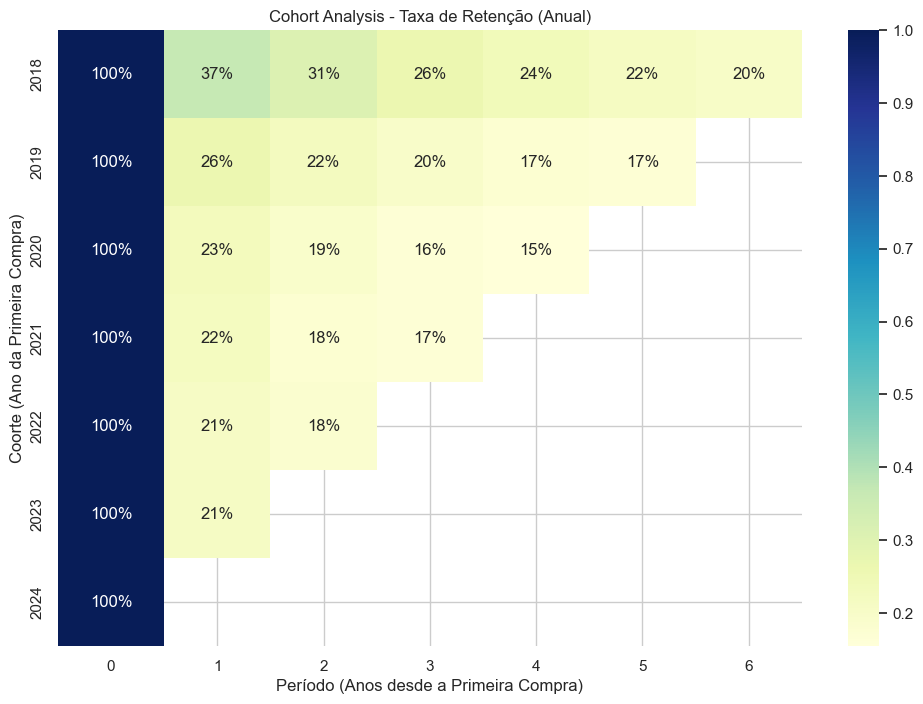

Tabela de Retenção por Cohort (Anual):
period_index    0         1         2         3         4         5         6
cohort_year                                                                  
2018          1.0  0.368707  0.309408  0.264238  0.239110  0.215068  0.203504
2019          1.0  0.264959  0.223704  0.199926  0.174401  0.169756       NaN
2020          1.0  0.228592  0.191481  0.164285  0.154204       NaN       NaN
2021          1.0  0.223461  0.176158  0.166579       NaN       NaN       NaN
2022          1.0  0.208819  0.183257       NaN       NaN       NaN       NaN
2023          1.0  0.212407       NaN       NaN       NaN       NaN       NaN
2024          1.0       NaN       NaN       NaN       NaN       NaN       NaN


In [50]:
# ---- Análise de Cohort: Agrupando Clientes em Coortes Anuais com Base na Primeira Compra ----

# Utilizaremos a base de dados df_vendas que já possui a coluna 'data_venda' no formato datetime.
# Cada pedido será associado a um período anual, e cada cliente receberá a coorte (ano) de sua primeira compra.

# 1. Definir o período do pedido como ano
df_vendas['order_period'] = df_vendas['data_venda'].dt.to_period('A')

# 2. Para cada cliente, identificar a data da primeira compra e definir sua coorte anual
first_purchase = df_vendas.groupby('id_cliente')['data_venda'].min().reset_index()
first_purchase.columns = ['id_cliente', 'first_purchase_date']
first_purchase['cohort_year'] = first_purchase['first_purchase_date'].dt.to_period('A')

# 3. Mesclar a informação da coorte (ano da primeira compra) de volta à base de pedidos
df_vendas = pd.merge(df_vendas, first_purchase[['id_cliente', 'cohort_year']], on='id_cliente')

# 4. Calcular o índice do período (em anos) para cada pedido: quantos anos se passaram desde a coorte
df_vendas['period_index'] = (df_vendas['order_period'] - df_vendas['cohort_year']).apply(lambda x: x.n)

# 5. Agregar os dados para contar o número de clientes únicos por coorte e por período
cohort_data = df_vendas.groupby(['cohort_year', 'period_index'])['id_cliente'].nunique().reset_index()
cohort_data.rename(columns={'id_cliente': 'num_customers'}, inplace=True)

# 6. Obter o tamanho inicial de cada coorte (ou seja, o número de clientes no período 0)
cohort_sizes = cohort_data[cohort_data['period_index'] == 0][['cohort_year', 'num_customers']]
cohort_sizes.rename(columns={'num_customers': 'cohort_size'}, inplace=True)

# 7. Mesclar o tamanho da coorte com os dados agregados
cohort_data = pd.merge(cohort_data, cohort_sizes, on='cohort_year')

# 8. Calcular a taxa de retenção para cada coorte e período:
#    Taxa de Retenção = Número de clientes ativos no período / Tamanho inicial da coorte
cohort_data['retention_rate'] = cohort_data['num_customers'] / cohort_data['cohort_size']

# 9. Criar uma tabela dinâmica (pivot table) para visualizar a retenção ao longo dos anos
cohort_pivot = cohort_data.pivot(index='cohort_year', columns='period_index', values='retention_rate')

# 10. Plotar um mapa de calor para visualizar a evolução da retenção ao longo do tempo
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_pivot, annot=True, fmt='.0%', cmap='YlGnBu')
plt.title('Cohort Analysis - Taxa de Retenção (Anual)')
plt.ylabel('Coorte (Ano da Primeira Compra)')
plt.xlabel('Período (Anos desde a Primeira Compra)')
plt.show()

# Exibir a tabela de retenção
print("Tabela de Retenção por Cohort (Anual):")
cohort_data.to_excel('metricas_retencao_anual.xlsx', index=False)
print(cohort_pivot)

#### CÁLCULO RFMA

In [51]:
# Recency: Número de dias desde a última compra
data_referencia = df_vendas['data_venda'].max()
recency = df_vendas.groupby('id_cliente')['data_venda'].max().apply(lambda x: (data_referencia - x).days)

# Frequency: Número de pedidos únicos por cliente
frequency = df_vendas.groupby('id_cliente')['id_venda'].nunique()

# Monetary: Valor total gasto
monetary = df_vendas.groupby('id_cliente').apply(
    lambda x: (x['total_venda'] * np.where(x['status'] == 'Devolução', -1, 1)).sum()
)

# Age (Antiguidade): Dias desde a primeira compra
age = df_vendas.groupby('id_cliente')['data_venda'].min().apply(lambda x: (data_referencia - x).days)

# Combinar métricas em um único DataFrame
rfma = pd.DataFrame({
    'Recency': recency,
    'Frequency': frequency,
    'Monetary': monetary,
    'Age': age
})

# Resetar o índice para ter id_cliente como coluna
rfma = rfma.reset_index()

# Adicionar algumas verificações
print("\nEstatísticas das métricas RFMA:")
print("\nRecency (dias):")
print(rfma['Recency'].describe())
print("\nFrequency (número de pedidos):")
print(rfma['Frequency'].describe())
print("\nMonetary (valor total):")
print(rfma['Monetary'].describe())
print("\nAge (dias desde primeira compra):")
print(rfma['Age'].describe())

#Salvar o resultado em um arquivo CSV
# rfma.to_csv('RFMA_por_cliente.csv', index=False)

# Exibir o DataFrame RFMA
print("\nPrimeiras linhas do RFMA:")
print(rfma.head())

# Verificações adicionais
print("\nContagens de controle:")
print(f"Número total de clientes: {len(rfma)}")

# Verificação adicional para Age
print("\nVerificação de coerência:")
print("Clientes com Age menor que Recency:", len(rfma[rfma['Age'] < rfma['Recency']]))


Estatísticas das métricas RFMA:

Recency (dias):
count    115099.000000
mean       1001.640240
std         728.501816
min           0.000000
25%         330.000000
50%         907.000000
75%        1585.000000
max        2466.000000
Name: Recency, dtype: float64

Frequency (número de pedidos):
count    115099.000000
mean          3.868904
std           6.029915
min           1.000000
25%           2.000000
50%           2.000000
75%           4.000000
max         393.000000
Name: Frequency, dtype: float64

Monetary (valor total):
count     115099
unique     22001
top       180.00
freq        2279
Name: Monetary, dtype: object

Age (dias desde primeira compra):
count    115099.000000
mean       1450.756940
std         726.770808
min           0.000000
25%         868.000000
50%        1550.000000
75%        2110.000000
max        2466.000000
Name: Age, dtype: float64

Primeiras linhas do RFMA:
   id_cliente  Recency  Frequency  Monetary   Age
0           2      218          6   3489.00

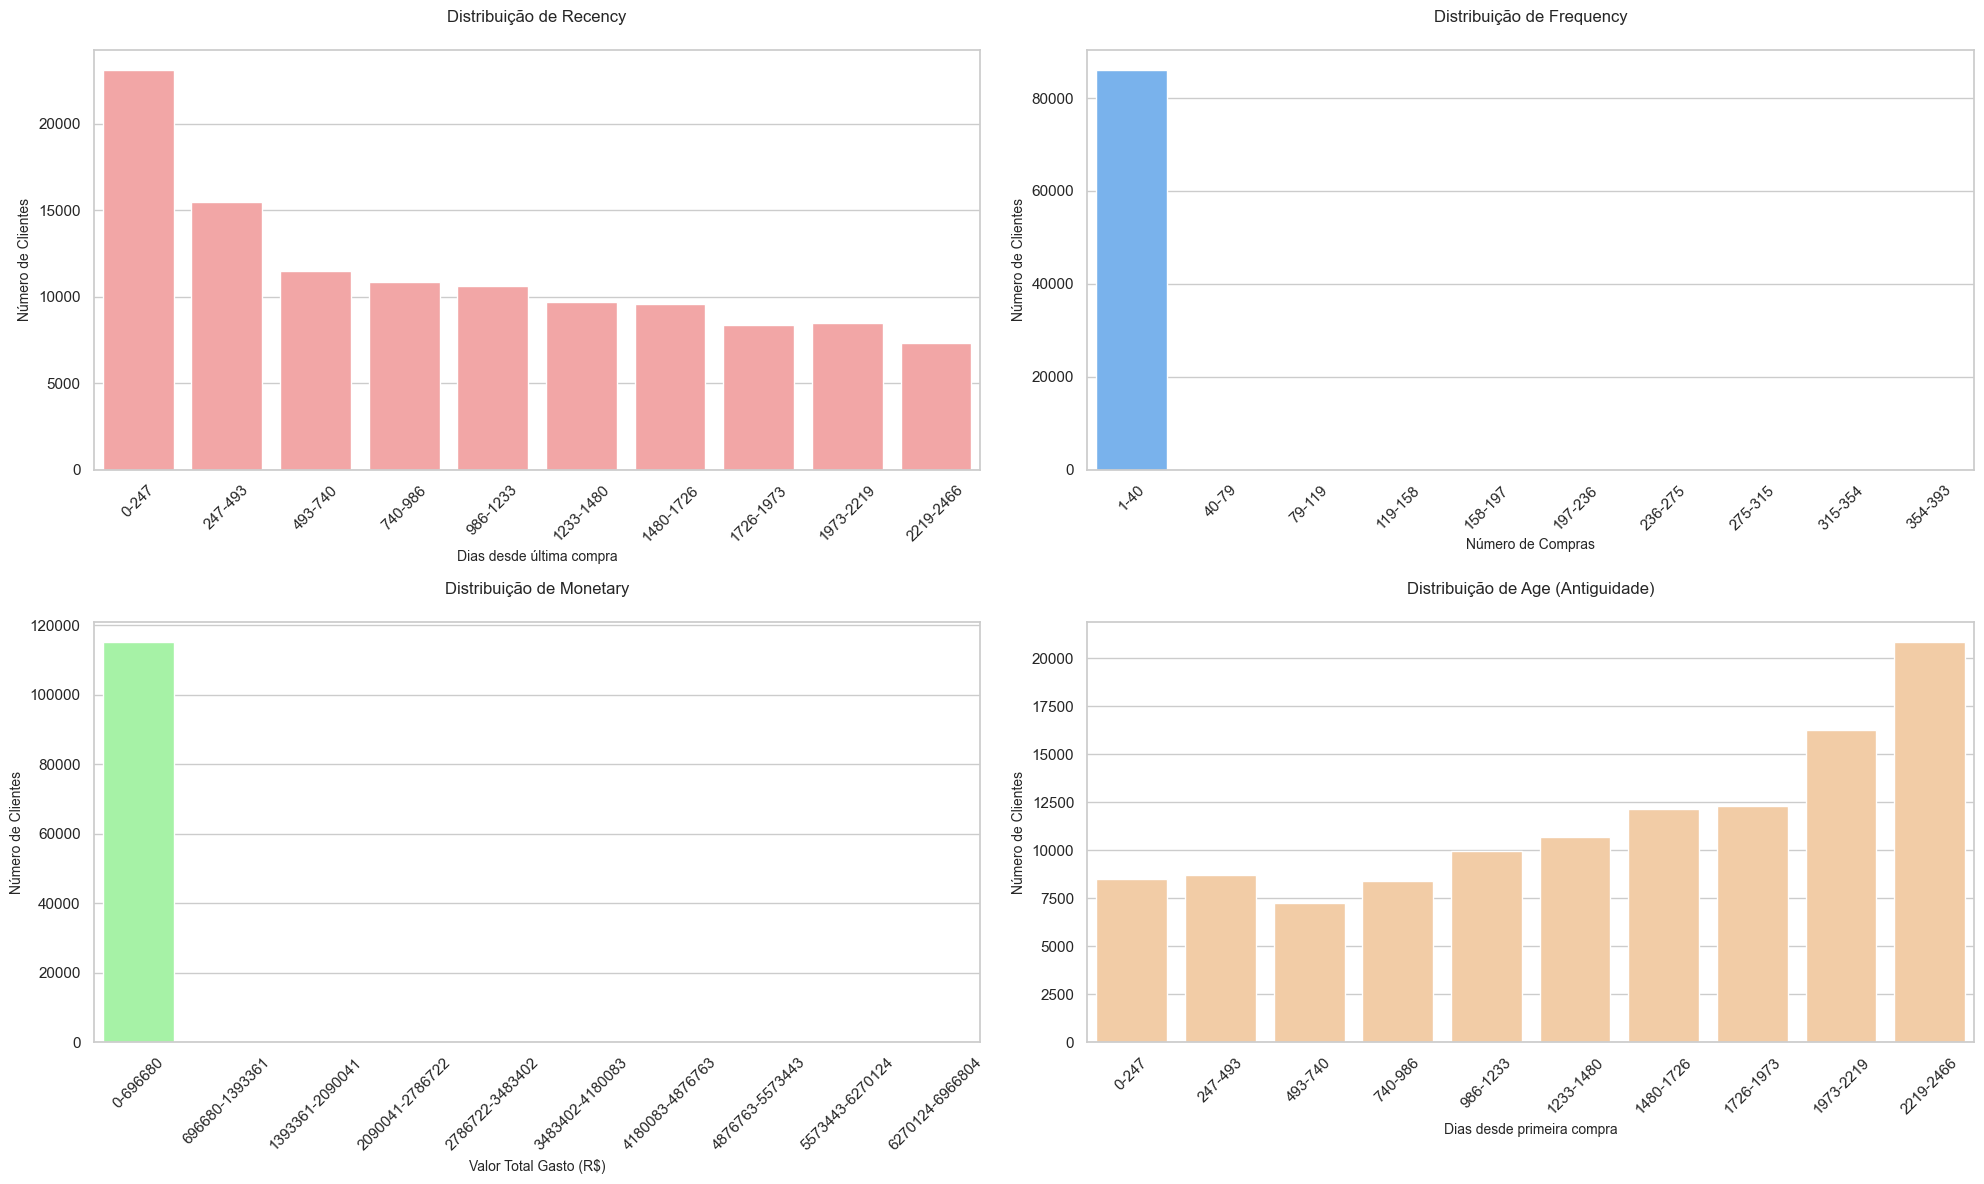


Distribuição de clientes por faixa:

Recency (dias):
R_range
0-247        23123
247-493      15479
493-740      11520
740-986      10847
986-1233     10612
1233-1480     9694
1480-1726     9563
1726-1973     8354
1973-2219     8506
2219-2466     7356
Name: count, dtype: int64

Frequency (compras):
F_range
1-40       86060
40-79        235
79-119        38
119-158       15
158-197        4
197-236        6
236-275        4
275-315        1
315-354        1
354-393        2
Name: count, dtype: int64

Monetary (R$):
M_range
0-696680           115076
696680-1393361          5
1393361-2090041         2
2090041-2786722         1
2786722-3483402         1
3483402-4180083         0
4180083-4876763         0
4876763-5573443         1
5573443-6270124         0
6270124-6966804         1
Name: count, dtype: int64

Age (dias desde primeira compra):
A_range
0-247         8517
247-493       8684
493-740       7263
740-986       8419
986-1233      9958
1233-1480    10691
1480-1726    12147
1726-1973 

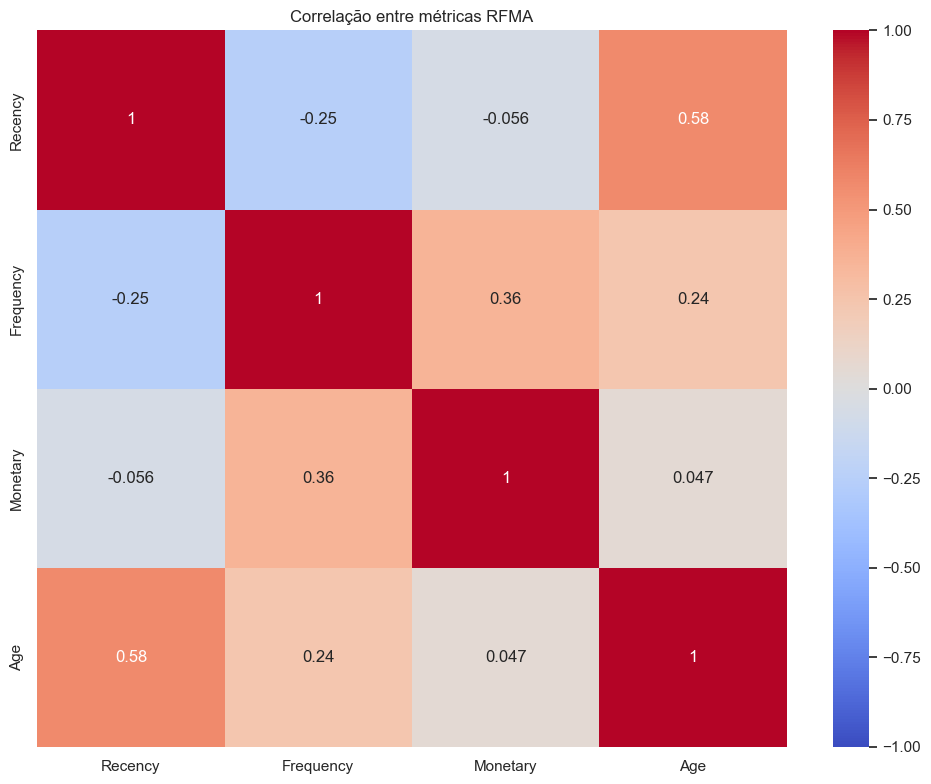

In [52]:
# Configuração básica do seaborn
sns.set(style="whitegrid")

# Criar bins e labels para cada métrica
def create_range_labels(data, bins):
    labels = []
    for i in range(len(bins)-1):
        labels.append(f'{bins[i]:.0f}-{bins[i+1]:.0f}')
    return labels

# Definir uma paleta de cores atraente
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']

# Recency
r_bins = np.linspace(rfma['Recency'].min(), rfma['Recency'].max(), 11)
r_labels = create_range_labels(rfma['Recency'], r_bins)
rfma['R_range'] = pd.cut(rfma['Recency'], bins=r_bins, labels=r_labels)

# Frequency
f_bins = np.linspace(rfma['Frequency'].min(), rfma['Frequency'].max(), 11)
f_labels = create_range_labels(rfma['Frequency'], f_bins)
rfma['F_range'] = pd.cut(rfma['Frequency'], bins=f_bins, labels=f_labels)

# Monetary
m_bins = np.linspace(rfma['Monetary'].min(), rfma['Monetary'].max(), 11)
m_labels = create_range_labels(rfma['Monetary'], m_bins)
rfma['M_range'] = pd.cut(rfma['Monetary'], bins=m_bins, labels=m_labels)

# Age (Antiguidade)
a_bins = np.linspace(rfma['Age'].min(), rfma['Age'].max(), 11)
a_labels = create_range_labels(rfma['Age'], a_bins)
rfma['A_range'] = pd.cut(rfma['Age'], bins=a_bins, labels=a_labels)

# Criar gráficos
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Gráfico de Recency
r_counts = rfma['R_range'].value_counts().sort_index()
sns.barplot(x=r_counts.index, y=r_counts.values, ax=axes[0,0], color=colors[0])
axes[0,0].set_title('Distribuição de Recency', fontsize=12, pad=20)
axes[0,0].set_xlabel('Dias desde última compra', fontsize=10)
axes[0,0].set_ylabel('Número de Clientes', fontsize=10)
axes[0,0].tick_params(axis='x', rotation=45)

# Gráfico de Frequency
f_counts = rfma['F_range'].value_counts().sort_index()
sns.barplot(x=f_counts.index, y=f_counts.values, ax=axes[0,1], color=colors[1])
axes[0,1].set_title('Distribuição de Frequency', fontsize=12, pad=20)
axes[0,1].set_xlabel('Número de Compras', fontsize=10)
axes[0,1].set_ylabel('Número de Clientes', fontsize=10)
axes[0,1].tick_params(axis='x', rotation=45)

# Gráfico de Monetary
m_counts = rfma['M_range'].value_counts().sort_index()
sns.barplot(x=m_counts.index, y=m_counts.values, ax=axes[1,0], color=colors[2])
axes[1,0].set_title('Distribuição de Monetary', fontsize=12, pad=20)
axes[1,0].set_xlabel('Valor Total Gasto (R$)', fontsize=10)
axes[1,0].set_ylabel('Número de Clientes', fontsize=10)
axes[1,0].tick_params(axis='x', rotation=45)

# Gráfico de Age (Antiguidade)
a_counts = rfma['A_range'].value_counts().sort_index()
sns.barplot(x=a_counts.index, y=a_counts.values, ax=axes[1,1], color=colors[3])
axes[1,1].set_title('Distribuição de Age (Antiguidade)', fontsize=12, pad=20)
axes[1,1].set_xlabel('Dias desde primeira compra', fontsize=10)
axes[1,1].set_ylabel('Número de Clientes', fontsize=10)
axes[1,1].tick_params(axis='x', rotation=45)

# Ajustar o layout
plt.tight_layout()
plt.show()

# Imprimir distribuição
print("\nDistribuição de clientes por faixa:")
print("\nRecency (dias):")
print(r_counts)
print("\nFrequency (compras):")
print(f_counts)
print("\nMonetary (R$):")
print(m_counts)
print("\nAge (dias desde primeira compra):")
print(a_counts)

# Análises adicionais de correlação
correlation_matrix = rfma[['Recency', 'Frequency', 'Monetary', 'Age']].corr()

# Plotar mapa de calor das correlações
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlação entre métricas RFMA')
plt.tight_layout()
plt.show()

#### RFMA - ANÁLISE DE CLIENTES POR DECIS

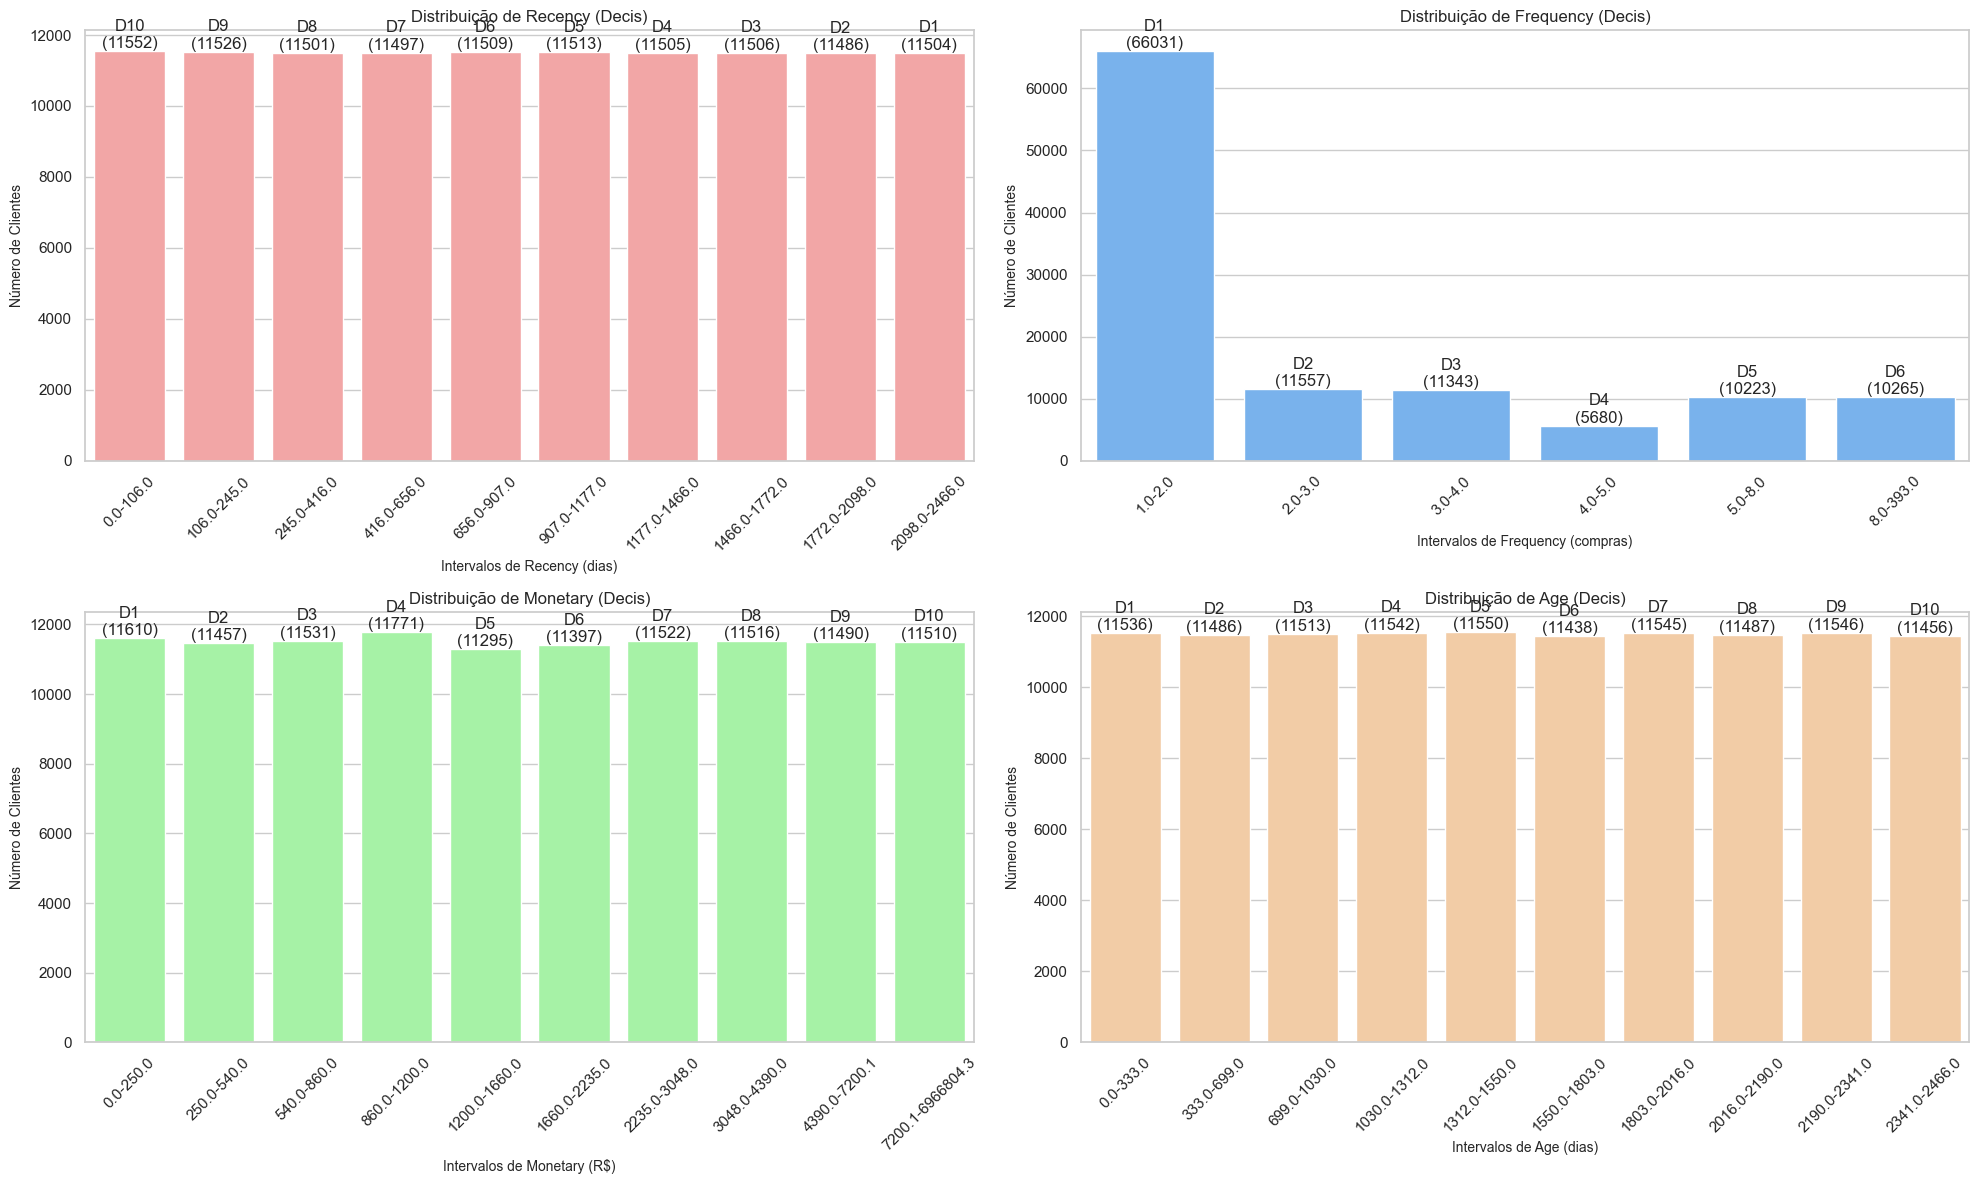


Exemplo dos primeiros registros com decis:
   Recency R_decil  Frequency F_decil  Monetary M_decil     Age A_decil
0    218.0       9        6.0       5   3489.00       8  2358.0      10
1   1929.0       2       12.0       6  45254.00      10  2343.0      10
2    614.0       7        5.0       4   5964.00       9  2232.0       9
3   2203.0       1        2.0       1   2680.00       7  2203.0       9
4    445.0       7       10.0       6   1834.18       6  2466.0      10

Distribuição de clientes por faixa:

Recency (Ranges):
R_range
0.0-106.0        11552
106.0-245.0      11526
245.0-416.0      11501
416.0-656.0      11497
656.0-907.0      11509
907.0-1177.0     11513
1177.0-1466.0    11505
1466.0-1772.0    11506
1772.0-2098.0    11486
2098.0-2466.0    11504
Name: count, dtype: int64

Frequency (Ranges):
F_range
1.0-2.0      66031
2.0-3.0      11557
3.0-4.0      11343
4.0-5.0       5680
5.0-8.0      10223
8.0-393.0    10265
Name: count, dtype: int64

Monetary (Ranges):
M_range
0.0-250

In [53]:
# Converter as colunas para float (caso estejam em decimal.Decimal)
for col in ['Recency', 'Frequency', 'Monetary', 'Age']:
    rfma[col] = rfma[col].astype(float)

# Criar decis para cada métrica RFMA
# Primeiro vamos obter os bins para cada métrica
_, r_bins = pd.qcut(rfma['Recency'], q=10, duplicates='drop', retbins=True)
_, f_bins = pd.qcut(rfma['Frequency'], q=10, duplicates='drop', retbins=True)
_, m_bins = pd.qcut(rfma['Monetary'], q=10, duplicates='drop', retbins=True)
_, a_bins = pd.qcut(rfma['Age'], q=10, duplicates='drop', retbins=True)

# Agora criar os labels com o número correto de categorias
r_labels = list(range(len(r_bins)-1, 0, -1))  # Ordem inversa para Recency
f_labels = list(range(1, len(f_bins)))  # Ordem normal para os demais
m_labels = list(range(1, len(m_bins)))
a_labels = list(range(1, len(a_bins)))

# Aplicar os decis
rfma['R_decil'] = pd.qcut(rfma['Recency'], q=10, labels=r_labels, duplicates='drop')
rfma['F_decil'] = pd.qcut(rfma['Frequency'], q=10, labels=f_labels, duplicates='drop')
rfma['M_decil'] = pd.qcut(rfma['Monetary'], q=10, labels=m_labels, duplicates='drop')
rfma['A_decil'] = pd.qcut(rfma['Age'], q=10, labels=a_labels, duplicates='drop')

# Criar ranges para visualização
r_bins = pd.qcut(rfma['Recency'], q=10, duplicates="drop", retbins=True)[1]
rfma['R_range'] = pd.cut(
    rfma['Recency'], 
    bins=r_bins, 
    labels=[f"{r_bins[i]:.1f}-{r_bins[i+1]:.1f}" for i in range(len(r_bins)-1)], 
    include_lowest=True
)

f_bins = pd.qcut(rfma['Frequency'], q=10, duplicates="drop", retbins=True)[1]
rfma['F_range'] = pd.cut(
    rfma['Frequency'], 
    bins=f_bins, 
    labels=[f"{f_bins[i]:.1f}-{f_bins[i+1]:.1f}" for i in range(len(f_bins)-1)], 
    include_lowest=True
)

m_bins = pd.qcut(rfma['Monetary'], q=10, duplicates="drop", retbins=True)[1]
rfma['M_range'] = pd.cut(
    rfma['Monetary'], 
    bins=m_bins, 
    labels=[f"{m_bins[i]:.1f}-{m_bins[i+1]:.1f}" for i in range(len(m_bins)-1)], 
    include_lowest=True
)

a_bins = pd.qcut(rfma['Age'], q=10, duplicates="drop", retbins=True)[1]
rfma['A_range'] = pd.cut(
    rfma['Age'], 
    bins=a_bins, 
    labels=[f"{a_bins[i]:.1f}-{a_bins[i+1]:.1f}" for i in range(len(a_bins)-1)], 
    include_lowest=True
)

# Configurar estilo do gráfico
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Gráfico de Recency
r_counts = rfma['R_range'].value_counts().sort_index()
sns.barplot(x=r_counts.index, y=r_counts.values, ax=axes[0,0], color='#FF9999')
axes[0,0].set_title('Distribuição de Recency (Decis)', fontsize=12)
axes[0,0].set_xlabel('Intervalos de Recency (dias)', fontsize=10)
axes[0,0].set_ylabel('Número de Clientes', fontsize=10)
axes[0,0].tick_params(axis='x', rotation=45)

# Adicionar valores e decis no topo das barras de Recency
for i, v in enumerate(r_counts):
    decil = 10 - i  # Decil invertido para Recency
    axes[0,0].text(i, v, f'D{decil}\n({int(v)})', ha='center', va='bottom')

# Gráfico de Frequency
f_counts = rfma['F_range'].value_counts().sort_index()
sns.barplot(x=f_counts.index, y=f_counts.values, ax=axes[0,1], color='#66B2FF')
axes[0,1].set_title('Distribuição de Frequency (Decis)', fontsize=12)
axes[0,1].set_xlabel('Intervalos de Frequency (compras)', fontsize=10)
axes[0,1].set_ylabel('Número de Clientes', fontsize=10)
axes[0,1].tick_params(axis='x', rotation=45)

# Adicionar valores e decis no topo das barras de Frequency
for i, v in enumerate(f_counts):
    decil = i + 1
    axes[0,1].text(i, v, f'D{decil}\n({int(v)})', ha='center', va='bottom')

# Gráfico de Monetary
m_counts = rfma['M_range'].value_counts().sort_index()
sns.barplot(x=m_counts.index, y=m_counts.values, ax=axes[1,0], color='#99FF99')
axes[1,0].set_title('Distribuição de Monetary (Decis)', fontsize=12)
axes[1,0].set_xlabel('Intervalos de Monetary (R$)', fontsize=10)
axes[1,0].set_ylabel('Número de Clientes', fontsize=10)
axes[1,0].tick_params(axis='x', rotation=45)

# Adicionar valores e decis no topo das barras de Monetary
for i, v in enumerate(m_counts):
    decil = i + 1
    axes[1,0].text(i, v, f'D{decil}\n({int(v)})', ha='center', va='bottom')

# Gráfico de Age (Antiguidade)
a_counts = rfma['A_range'].value_counts().sort_index()
sns.barplot(x=a_counts.index, y=a_counts.values, ax=axes[1,1], color='#FFCC99')
axes[1,1].set_title('Distribuição de Age (Decis)', fontsize=12)
axes[1,1].set_xlabel('Intervalos de Age (dias)', fontsize=10)
axes[1,1].set_ylabel('Número de Clientes', fontsize=10)
axes[1,1].tick_params(axis='x', rotation=45)

# Adicionar valores e decis no topo das barras de Age
for i, v in enumerate(a_counts):
    decil = i + 1
    axes[1,1].text(i, v, f'D{decil}\n({int(v)})', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Imprimir exemplo dos primeiros registros com os decis
print("\nExemplo dos primeiros registros com decis:")
print(rfma[['Recency', 'R_decil', 'Frequency', 'F_decil', 
            'Monetary', 'M_decil', 'Age', 'A_decil']].head())

# Imprimir distribuição
print("\nDistribuição de clientes por faixa:")
print("\nRecency (Ranges):")
print(r_counts)
print("\nFrequency (Ranges):")
print(f_counts)
print("\nMonetary (Ranges):")
print(m_counts)
print("\nAge (Ranges):")
print(a_counts)

#### RFMA - SEGMENTAÇÃO BASEADA EM REGRAS

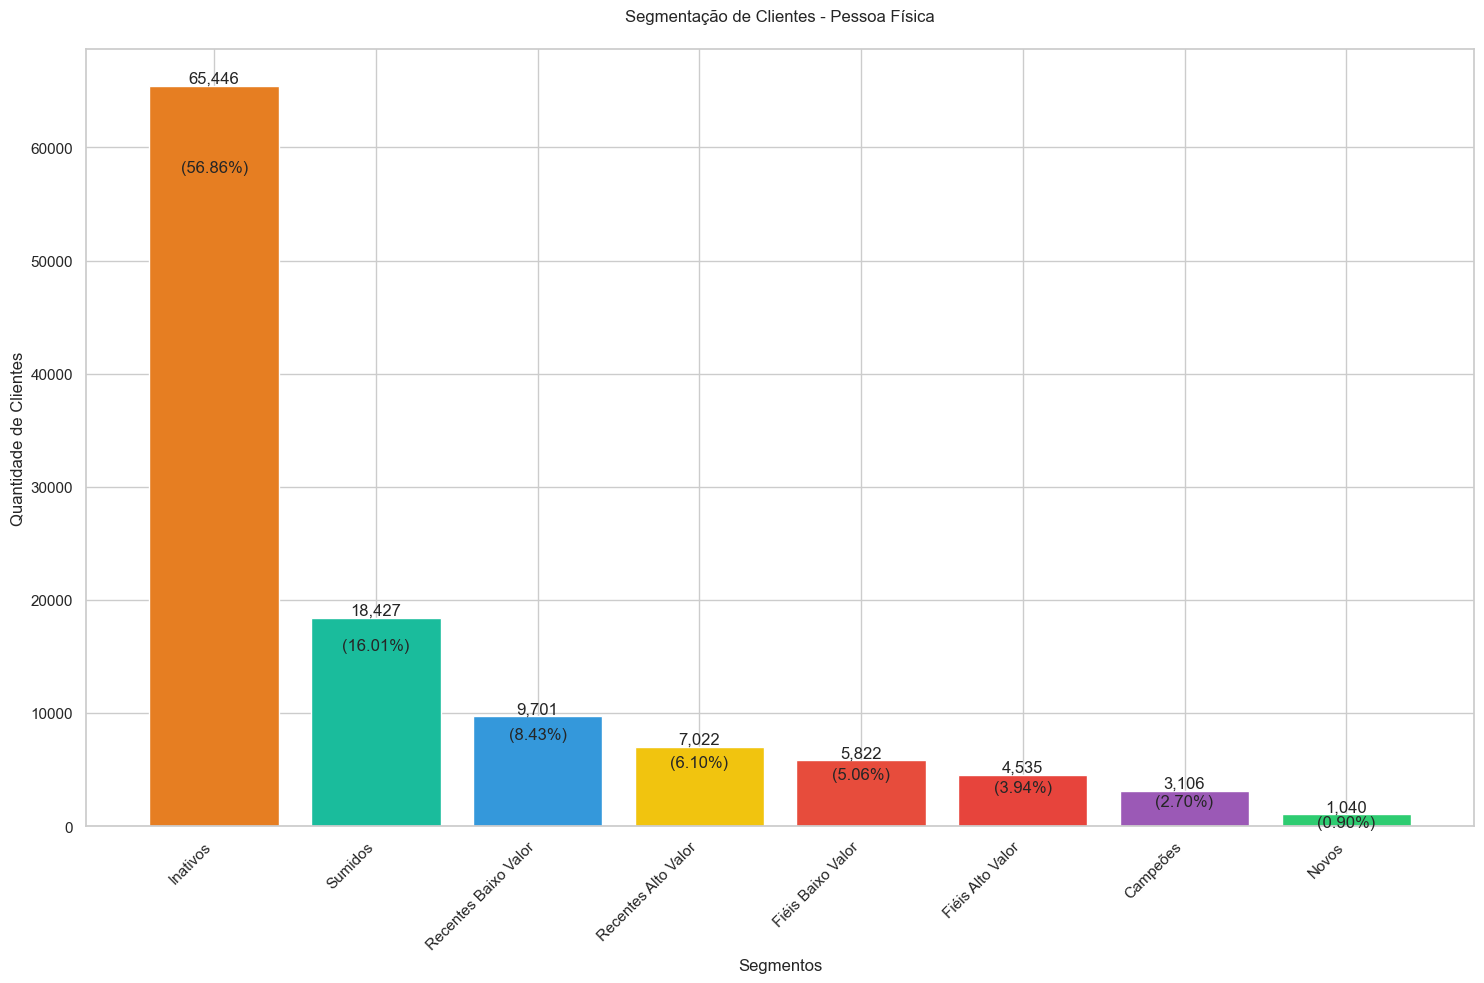


Análise Detalhada por Segmento:
                      Quantidade Clientes  Média Recency (dias)  \
Segmento                                                          
Inativos                            65446               1532.79   
Sumidos                             18427                538.21   
Recentes Baixo Valor                 9701                183.87   
Recentes Alto Valor                  7022                166.17   
Fiéis Baixo Valor                    5822                168.65   
Fiéis Alto Valor                     4535                191.73   
Campeões                             3106                 76.77   
Novos                                1040                 14.58   

                      Média Frequency  Média Monetary (R$)  Média Age (dias)  
Segmento                                                                      
Inativos                         2.68              2467.78           1739.67  
Sumidos                          4.15              4540.55 

In [54]:
def segment_customers(df):
    """
    Segmenta clientes com base em regras atualizadas, de acordo com a análise da distribuição por faixa.
    
    Parâmetros:
    - Recency: dias desde a última compra
    - Age: dias desde a primeira compra (antiguidade)
    - Frequency: número de compras
    - Monetary: valor médio das compras
    """
    # Criar cópia do dataframe
    df_seg = df.copy()
    
    cond_novos = (df_seg['Recency'] <= 30) & (df_seg['Age'] <= 30) # compraram no mês anterior
    
    cond_campeoes = (df_seg['Recency'] <= 180) & \
                    (df_seg['Frequency'] >= 8) & (df_seg['M_decil'] == 10) # compraram nos últimos 6 meses, possuem frequência de 8 ou mais e são top 10% de valor monetário
                    
    cond_fieis_baixo_valor = (df_seg['Recency'] <= 365) & (df_seg['Age'] >= 1095) & \
                 (df_seg['Frequency'] >= 3) & (df_seg['M_decil'] <= 8) # clientes há mais de 3 anos que compraram no último ano e são top 10% de valor monetário
    
    cond_fieis_alto_valor = (df_seg['Recency'] <= 365) & (df_seg['Age'] >= 1095) & \
                 (df_seg['Frequency'] >= 3) & (df_seg['M_decil'] > 8) # clientes há mais de 3 anos que compraram no último ano e possuem valor monetário abaixo do top 20% 
                 
    cond_recentes_alto = (df_seg['Recency'] <= 365) & \
                         (df_seg['Frequency'] >= 1) & (df_seg['M_decil'] > 4) # clientes que compraram no último ano e possuem valor monetário acima da média
                         
    cond_recentes_baixo = (df_seg['Recency'] <= 365) & \
                          (df_seg['Frequency'] >= 1) & (df_seg['M_decil'] <= 4) # clientes que compraram no último ano e possuem valor monetário abaixo da média
    
    # Clientes menos ativos
    cond_sumidos = (df_seg['Recency'] > 365) & (df_seg['Recency'] <= 730) # última compra entre 1 e 2 anos
    cond_inativos = (df_seg['Recency'] > 730) # sem comprar faz 2 anos
    
    # Lista de condições e respectivos rótulos
    conditions = [
        cond_novos,
        cond_campeoes,
        cond_fieis_baixo_valor,
        cond_fieis_alto_valor,
        cond_recentes_alto,
        cond_recentes_baixo,
        cond_sumidos,
        cond_inativos
    ]
    
    labels = [
        'Novos',
        'Campeões',
        'Fiéis Baixo Valor',
        'Fiéis Alto Valor',
        'Recentes Alto Valor',
        'Recentes Baixo Valor',
        'Sumidos',
        'Inativos'
    ]
    
    # Aplicar segmentação
    df_seg['Segmento'] = np.select(conditions, labels, default='Não Classificado')
    
    # Definir cores para cada segmento
    cores_segmento = {
        'Novos': '#2ecc71',              # Verde
        'Campeões': '#9b59b6',           # Roxo
        'Fiéis Baixo Valor': '#e74c3c',  # Vermelho
        'Fiéis Alto Valor' : '#e7443c',  
        'Recentes Alto Valor': '#f1c40f', # Amarelo
        'Recentes Baixo Valor': '#3498db',# Azul
        'Sumidos': '#1abc9c',             # Turquesa
        'Inativos': '#e67e22'             # Laranja
    }
    
    # Agregar dados para análise dos segmentos
    analise_segmentos = df_seg.groupby('Segmento').agg({
        'id_cliente': 'count',
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': 'mean',
        'Age': 'mean'
    }).round(2)
    
    analise_segmentos.columns = [
        'Quantidade Clientes',
        'Média Recency (dias)',
        'Média Frequency',
        'Média Monetary (R$)',
        'Média Age (dias)'
    ]
    
    # Ordenar por quantidade de clientes
    analise_segmentos = analise_segmentos.sort_values('Quantidade Clientes', ascending=False)
    
    # Visualização dos segmentos
    plt.figure(figsize=(15, 10))
    total_clientes = analise_segmentos['Quantidade Clientes'].sum()
    
    bars = plt.bar(
        analise_segmentos.index,
        analise_segmentos['Quantidade Clientes'],
        color=[cores_segmento.get(seg, '#95a5a6') for seg in analise_segmentos.index]
    )
    
    plt.title('Segmentação de Clientes - Pessoa Física', pad=20)
    plt.xlabel('Segmentos')
    plt.ylabel('Quantidade de Clientes')
    plt.xticks(rotation=45, ha='right')
    
    # Adicionar valores e porcentagens nas barras
    for bar in bars:
        height = bar.get_height()
        percentage = (height / total_clientes) * 100
        
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height,
            f'{int(height):,}',
            ha='center',
            va='bottom'
        )
        
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height * 0.9,
            f'({percentage:.2f}%)',
            ha='center',
            va='top'
        )
    
    plt.tight_layout()
    plt.show()
    
    return df_seg, analise_segmentos

# Usar a função
rfma_segmentado, analise = segment_customers(rfma)

# Salvar resultados
# rfma_segmentado.to_excel('rfma_segmentado_regras.xlsx', index=False)
# print("\nResultados salvos em 'rfma_segmentado_regras.xlsx'")

# Exibir análise
print("\nAnálise Detalhada por Segmento:")
print("=" * 120)
print(analise)

#### Preparando dados para o Dashboard da espantalho

In [55]:
rfma_segmentado = rfma_segmentado.merge(df_clientes_PF[['id_cliente', 'nome', 'cpf']], on='id_cliente', how='left')
rfma_segmentado = rfma_segmentado.merge(df_clientes[['id_cliente', 'email', 'telefone']], on='id_cliente', how='left')
print(rfma_segmentado.columns)
#Arquivo usado para o dash de segmentação
rfma_segmentado.to_csv('analytics_cliente_Espantalho_PF.csv', index=False)

Index(['id_cliente', 'Recency', 'Frequency', 'Monetary', 'Age', 'R_range',
       'F_range', 'M_range', 'A_range', 'R_decil', 'F_decil', 'M_decil',
       'A_decil', 'Segmento', 'nome', 'cpf', 'email', 'telefone'],
      dtype='object')


#### PREDIÇÃO DE COMPRAS POR CLIENTE NOS PRÓXIMOS 30 DIAS

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lifetimes/fitters/__init__.py:101: OptimizeWarning: Unknown solver options: iterative_fitting
  output = minimize(


Optimization terminated successfully.
         Current function value: -17.453953
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14

Parâmetros do Modelo:
<lifetimes.BetaGeoFitter: fitted with 20454 subjects, a: 0.20, alpha: 294.18, b: 2.26, r: 2.19>

Estatísticas das Previsões:
count    20044.000000
mean         0.117184
std          0.096698
min          0.000002
25%          0.044875
50%          0.103375
75%          0.162506
max          0.564286
Name: predicted_purchases_30d, dtype: float64


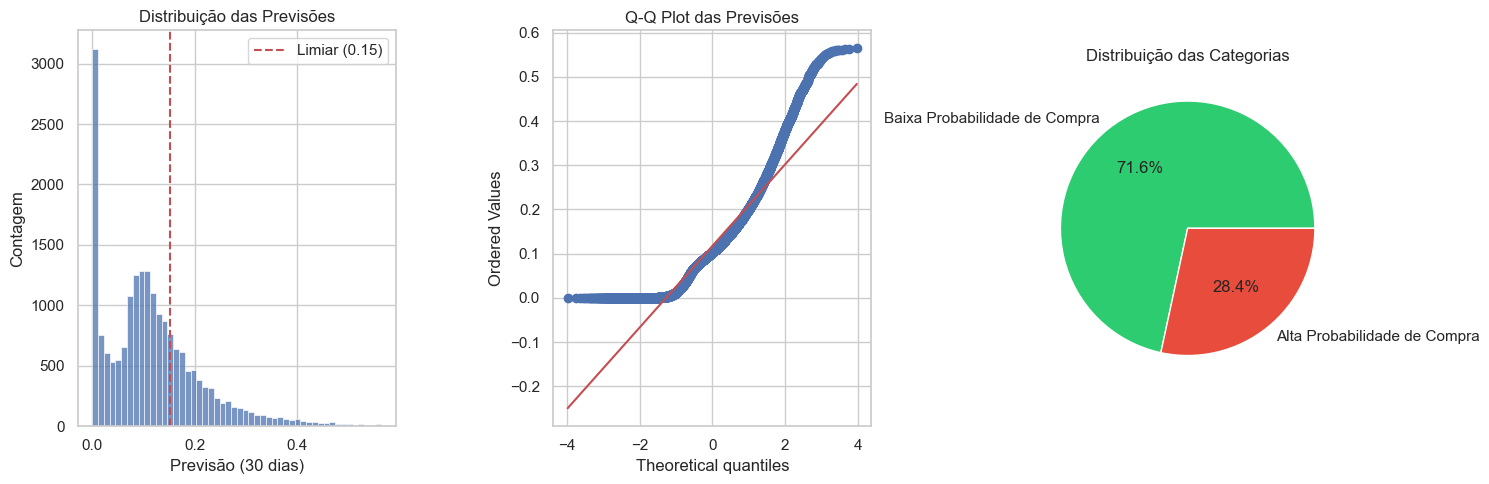


Análise por Categoria de Previsão:
                              Frequency               Recency         \
                                   mean median  count    mean median   
categoria_previsao                                                     
Alta Probabilidade de Compra      15.49   14.0   5688  132.44  111.0   
Baixa Probabilidade de Compra      8.66    8.0  14356  664.25  558.0   

                               Monetary         predicted_purchases_30d  \
                                   mean  median                    mean   
categoria_previsao                                                        
Alta Probabilidade de Compra   15208.88  9393.5                    0.24   
Baixa Probabilidade de Compra   8187.42  5312.2                    0.07   

                                                  
                              median   min   max  
categoria_previsao                                
Alta Probabilidade de Compra    0.21  0.15  0.56  
Baixa Probabilidade de 

In [56]:
# Pré-processamento para o modelo BG/NBD
rfma = rfma_segmentado.copy()

# Limpeza e tratamento dos dados
rfma = rfma[rfma['Frequency'] > 5]

# Ajustar os valores para evitar problemas numéricos
rfma['frequency_adjusted'] = rfma['Frequency'] - 1
rfma['recency_bg'] = (rfma['Age'] - rfma['Recency']).clip(lower=1)  # Garantir valores positivos
rfma['T'] = rfma['Age'].clip(lower=1)  # Garantir valores positivos

# Remover outliers extremos
for col in ['frequency_adjusted', 'recency_bg', 'T']:
    Q1 = rfma[col].quantile(0.01)
    Q3 = rfma[col].quantile(0.99)
    IQR = Q3 - Q1
    rfma = rfma[
        (rfma[col] >= Q1 - 1.5 * IQR) &
        (rfma[col] <= Q3 + 1.5 * IQR)
    ]

# Ajuste do Modelo BG/NBD com parâmetros para melhor convergência
bgf = BetaGeoFitter(penalizer_coef=0.01)  # Aumentar penalizador
bgf.fit(
    rfma['frequency_adjusted'],
    rfma['recency_bg'],
    rfma['T'],
    iterative_fitting=2,          # Reduzir número de iterações
    tol=1e-4,                     # Aumentar tolerância
    initial_params=None,          # Permitir estimativa automática
    verbose=True                  # Mostrar progresso
)

# Calcular previsões para 30 dias
rfma['predicted_purchases_30d'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    30,
    rfma['frequency_adjusted'],
    rfma['recency_bg'],
    rfma['T']
)

# Remover previsões extremas ou inválidas
rfma = rfma[rfma['predicted_purchases_30d'].between(
    rfma['predicted_purchases_30d'].quantile(0.01),
    rfma['predicted_purchases_30d'].quantile(0.99)
)]

# Imprimir parâmetros do modelo
print("\nParâmetros do Modelo:")
print(bgf)
print("\nEstatísticas das Previsões:")
print(rfma['predicted_purchases_30d'].describe())

# Definir limiar usando método mais robusto
limiar = rfma['predicted_purchases_30d'].median() + \
         rfma['predicted_purchases_30d'].std() * 0.5

# Classificar clientes
rfma['categoria_previsao'] = np.where(
    rfma['predicted_purchases_30d'] >= limiar,
    'Alta Probabilidade de Compra',
    'Baixa Probabilidade de Compra'
)

# Visualizações
plt.figure(figsize=(15, 5))

# 1. Distribuição das Previsões
plt.subplot(1, 3, 1)
sns.histplot(data=rfma, x='predicted_purchases_30d', bins=50)
plt.axvline(x=limiar, color='r', linestyle='--', label=f'Limiar ({limiar:.2f})')
plt.title('Distribuição das Previsões')
plt.xlabel('Previsão (30 dias)')
plt.ylabel('Contagem')
plt.legend()

# 2. QQ-Plot para verificar normalidade
plt.subplot(1, 3, 2)
from scipy.stats import probplot
probplot(rfma['predicted_purchases_30d'], dist="norm", plot=plt)
plt.title('Q-Q Plot das Previsões')

# 3. Contagem por Categoria
plt.subplot(1, 3, 3)
contagem = rfma['categoria_previsao'].value_counts()
plt.pie(contagem, labels=contagem.index, autopct='%1.1f%%',
        colors=['#2ecc71', '#e74c3c'])
plt.title('Distribuição das Categorias')

plt.tight_layout()
plt.show()

# Análise por categoria
print("\nAnálise por Categoria de Previsão:")
analise_categoria = rfma.groupby('categoria_previsao').agg({
    'Frequency': ['mean', 'median', 'count'],
    'Recency': ['mean', 'median'],
    'Monetary': ['mean', 'median'],
    'predicted_purchases_30d': ['mean', 'median', 'min', 'max']
}).round(2)

print(analise_categoria)

# Validação das previsões
print("\nValidação do Modelo:")
print(f"Média de transações previstas: {rfma['predicted_purchases_30d'].mean():.2f}")
print(f"Mediana de transações previstas: {rfma['predicted_purchases_30d'].median():.2f}")
print(f"% de clientes com alta probabilidade: {(rfma['categoria_previsao'] == 'Alta Probabilidade de Compra').mean()*100:.1f}%")

# Salvar resultados
rfma.to_excel('rfma_previsoes_ajustado.xlsx', index=False)
print("\nResultados salvos em 'rfma_previsoes_ajustado.xlsx'")

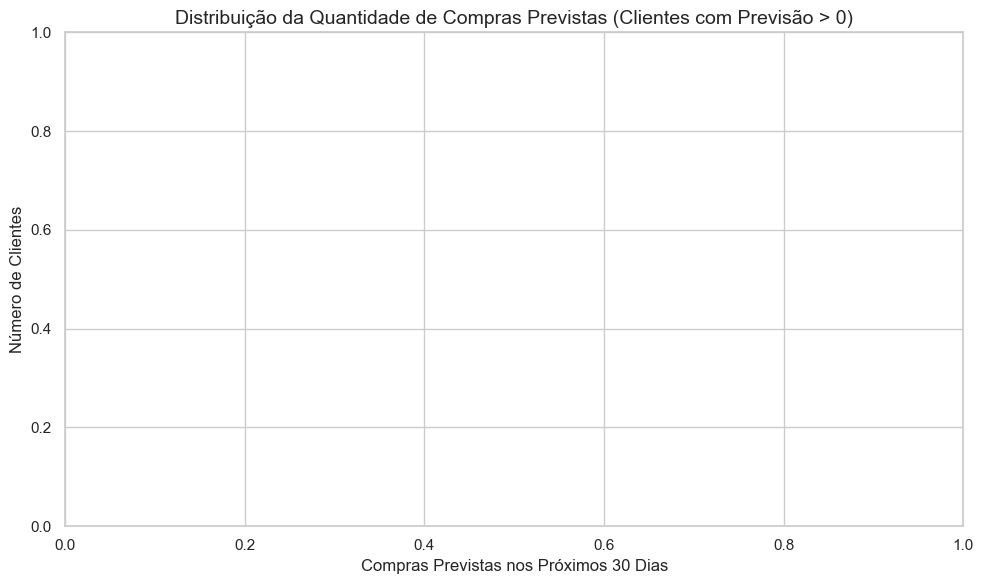

In [57]:
# Filtrar os clientes com previsão de compras > 0 utilizando .loc para garantir que uma Series seja retornada
dados = rfma.loc[rfma['predicted_purchases_30d'] > 0.8, 'predicted_purchases_30d']
plt.figure(figsize=(10, 6))
# Se o parâmetro edgecolor continuar causando problemas, remova-o:
sns.histplot(dados, bins=20, kde=True, color='blue')
# Caso deseje usar edgecolor, tente:
# sns.histplot(dados, bins=20, kde=True, color='blue', edgecolor='k')
plt.title('Distribuição da Quantidade de Compras Previstas (Clientes com Previsão > 0)', fontsize=14)
plt.xlabel('Compras Previstas nos Próximos 30 Dias', fontsize=12)
plt.ylabel('Número de Clientes', fontsize=12)
plt.tight_layout()
plt.show()

In [58]:
#### RFMA - SEGMENTAÇÃO KMEANS - DECIS RFMA

In [59]:
# # Contar o número de clientes por cluster (usando a coluna de nomes dos clusters)
# cluster_counts = rfma['Cluster'].value_counts().sort_index()

# # Criar lista de labels (nomes dos clusters) na mesma ordem dos índices
# labels = [cluster_names[i] for i in sorted(cluster_names.keys())]

# # Definir as cores para cada segmento (na mesma ordem dos clusters)
# pie_colors = ['#66B2FF', '#99FF99', '#FF9999', '#FFCC99', '#FF99CC']

# # Criar o gráfico de pizza
# plt.figure(figsize=(6,6))
# plt.pie(cluster_counts, labels=labels, autopct='%1.1f%%', colors=pie_colors, startangle=90)
# plt.title('Distribuição dos Segmentos')
# plt.axis('equal')  # Garante que o gráfico fique em formato circular
# plt.show()

In [60]:
# # Preparar dados para clustering (usando os decis já calculados)
# X = np.array([
#     rfma['R_decil'].astype(int),
#     rfma['F_decil'].astype(int),
#     rfma['M_decil'].astype(int),
#     rfma['A_decil'].astype(int)
# ]).T

# # Realizar o clustering diretamente nos decis
# n_clusters = 5
# kmeans = KMeans(n_clusters=n_clusters, random_state=42)
# clusters = kmeans.fit_predict(X)

# # Adicionar clusters ao DataFrame original
# rfma['Cluster'] = clusters

# # Criar mapeamento de nomes dos clusters
# cluster_names = {
#     0: 'Fiéis - Baixo Valor',  # Compras recentes, baixo valor, alta antiguidade
#     1: 'Inativos - Alto Valor', # Muito tempo sem comprar, alto valor
#     2: 'Inativos - Baixa Frequência',  # Recentes mas já inativos, valor médio
#     3: 'Em risco - Baixo Valor', # Valor baixo, reduzindo frequência
#     4: 'Em risco - Alto Valor'        # Antigos, alto valor, começando a se afastar
# }

# # Mapear números dos clusters para nomes
# rfma['Cluster_Nome'] = rfma['Cluster'].map(cluster_names)

# # Criar gráficos de barra para RFMA por cluster
# fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# # Definir cores para os clusters
# colors = ['#66B2FF', '#99FF99', '#FF9999', '#FFCC99', '#FF99CC']

# # 1. Gráfico de Recência
# r_cluster_counts = pd.crosstab(rfma['R_decil'], rfma['Cluster_Nome'])
# r_cluster_counts.plot(kind='bar', stacked=True, ax=axes[0,0], color=colors)
# axes[0,0].set_title('Distribuição de Recência por Cluster', fontsize=12)
# axes[0,0].set_xlabel('Decil de Recência (menor = mais recente)', fontsize=10)
# axes[0,0].set_ylabel('Número de Clientes', fontsize=10)
# axes[0,0].legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
# axes[0,0].tick_params(axis='x', rotation=0)

# # 2. Gráfico de Frequência
# f_cluster_counts = pd.crosstab(rfma['F_decil'], rfma['Cluster_Nome'])
# f_cluster_counts.plot(kind='bar', stacked=True, ax=axes[0,1], color=colors)
# axes[0,1].set_title('Distribuição de Frequência por Cluster', fontsize=12)
# axes[0,1].set_xlabel('Decil de Frequência (maior = mais frequente)', fontsize=10)
# axes[0,1].set_ylabel('Número de Clientes', fontsize=10)
# axes[0,1].legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
# axes[0,1].tick_params(axis='x', rotation=0)

# # 3. Gráfico de Valor Monetário
# m_cluster_counts = pd.crosstab(rfma['M_decil'], rfma['Cluster_Nome'])
# m_cluster_counts.plot(kind='bar', stacked=True, ax=axes[1,0], color=colors)
# axes[1,0].set_title('Distribuição de Valor Monetário por Cluster', fontsize=12)
# axes[1,0].set_xlabel('Decil de Valor Monetário (maior = maior valor)', fontsize=10)
# axes[1,0].set_ylabel('Número de Clientes', fontsize=10)
# axes[1,0].legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
# axes[1,0].tick_params(axis='x', rotation=0)

# # 4. Gráfico de Antiguidade
# a_cluster_counts = pd.crosstab(rfma['A_decil'], rfma['Cluster_Nome'])
# a_cluster_counts.plot(kind='bar', stacked=True, ax=axes[1,1], color=colors)
# axes[1,1].set_title('Distribuição de Antiguidade por Cluster', fontsize=12)
# axes[1,1].set_xlabel('Decil de Antiguidade (maior = mais antigo)', fontsize=10)
# axes[1,1].set_ylabel('Número de Clientes', fontsize=10)
# axes[1,1].legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
# axes[1,1].tick_params(axis='x', rotation=0)

# plt.tight_layout()
# plt.show()

# # Imprimir as contagens para cada combinação de decil e cluster
# print("\nDistribuição detalhada por variável (Dados usados para LLM nomear os 5 Clusters:")
# print("\nRecência (menor = mais recente):")
# print(r_cluster_counts)
# print("\nFrequência (maior = mais frequente):")
# print(f_cluster_counts)
# print("\nValor Monetário (maior = maior valor):")
# print(m_cluster_counts)
# print("\nAntiguidade (maior = mais antigo):")
# print(a_cluster_counts)
